In [12]:
from Updates import calc_update_shared_bdd, heat_sinc_boundary, initialise_boundary, update_without_source_2
from Updates import update_with_source, update_without_source, np, update_boundary_convection
import time 

t = []

q = 0.5*1e9 # W/m^3
T_a = 293 # K
K_si = 150 # W/mK
K_ceramic = 230 # W/mK
K_alu = 250 # W/mK
h = 1e-4 # m         

#%% initialising the system

ambient = 1

# set up the processor

vol_pr = 140*10

top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0_pr, T_k_pr = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

# set up the case

vol_cs = 200*20

top = np.array([ambient for i in range(200)])
bottom = top.copy()
left = np.array([ambient for i in range(20)])
right = left.copy()

T_0_cs, T_k_cs = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])


# set up the main body of the heat sinc (34x4)

sinc_length = 340
spacing = 20
vol_sinc = sinc_length*40

top = np.array([ambient for i in range(sinc_length)])
bottom = top.copy()
left = np.array([ambient for i in range(40)])
right = left.copy()

T_0_hs, T_k_hs = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

# set up fins for heat sinc

fin_length = 300

top = np.array([ambient for i in range(10)])
bottom = top.copy()
left = np.array([ambient for i in range(fin_length)])
right = left.copy()

n_fins = int((sinc_length+spacing)/(10+spacing))

vol_fins = n_fins*10*fin_length
fin_0, fin_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])
T_0_fn = np.array([fin_0 for i in range(n_fins)])
T_k_fn = np.array([fin_k for i in range(n_fins)])


#%% plot to see initial system

import Plotting as plot

plot.plot_whole_system(T_k_cs, T_k_pr, T_k_fn, T_k_hs, 0)

#%% fist boundary update: nat convection#########################################

t.append(time.time()) # 0
t.append(time.time()) # 1

T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr, K_si), update_boundary_convection(T_k_cs, K_ceramic)
T_0_hs_update = update_boundary_convection(T_k_hs, K_alu)

t.append(time.time()) # 2

T_0_fn_update = np.array([update_boundary_convection(np.matrix(fin_k), K_alu) for fin_k in T_k_fn])

#for fin_0, fin_k in zip(T_0_fn_update, T_k_fn):
#    fin_0 = update_boundary_convection(np.matrix(fin_k), K_alu)
    
t.append(time.time()) # 3
    
#%% fist boundary update: shared boundies #########################################

t.append(time.time()) # 4

T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr[2].A1, T_k_cs[-3].A1, K_si, K_ceramic, T_0_pr_update, T_0_cs_update)
T_0_cs_update, T_0_hs_update = calc_update_shared_bdd(T_k_cs[2].A1, T_k_hs[-3].A1, K_ceramic, K_alu, T_0_cs_update, T_0_hs_update)

t.append(time.time()) # 5

T_above_list = np.array([fin_k[-3] for fin_k in T_k_fn])
T_below = T_k_hs[-3].A1
T_0_hs_update, T_0_fn_update = heat_sinc_boundary(T_below, T_above_list, T_0_hs_update, T_0_fn_update)

t.append(time.time()) # 6

#%% fist inside update #################################


T_k_pr_update = update_with_source(T_k_pr, T_0_pr_update, q, h)

t.append(time.time()) # 7


T_k_cs_update = update_without_source(T_k_cs, T_0_cs_update)
T_k_hs_update = update_without_source(T_k_hs, T_0_hs_update)

t.append(time.time()) # 8

T_k_fn_update = np.array([update_without_source(np.matrix(fin_k), fin_0) for fin_0, fin_k in zip(T_0_fn_update, T_k_fn_update)])

t.append(time.time()) # 9

T_k_cs_update = update_without_source_2(T_k_cs, T_0_cs_update)
T_k_hs_update = update_without_source_2(T_k_hs, T_0_hs_update)

t.append(time.time())


ImportError: cannot import name 'update_without_source_2' from 'Updates' (C:\Users\Maxwell\OneDrive - Imperial College London\Heat_Dissipation_In_Microprocessors\Updates.py)

9.87467442264282

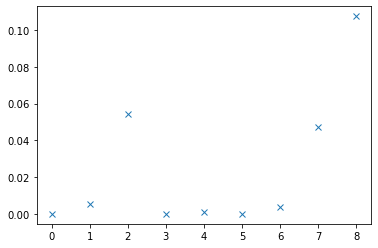

In [11]:
import matplotlib.pyplot as plt

diff_time = [t[i+1] - t[i] for i in range(len(t)-1)]

plt.plot([i for i in range(len(diff_time))], diff_time, 'x')

diff_time[2]/diff_time[1]

#10*300*12/(40*340 + 140*10 + 20*240)

1.8181818181818181

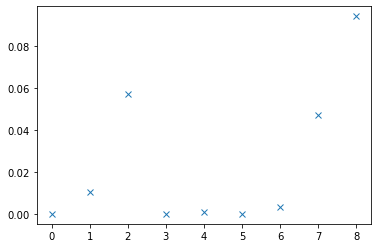

In [27]:
import matplotlib.pyplot as plt

diff_time = [t[i+1] - t[i] for i in range(len(t)-1)]

plt.plot([i for i in range(len(diff_time))], diff_time, 'x')

diff_time[2]/diff_time[1]

#10*300*12/(40*340 + 140*10 + 20*240)

In [ ]:
#%% iterations!!!

from Calculators import average_temp

avT_k_1 = 1.0059450123656382
diff_array = []
av_array = []

for i in range(10000):
    
    # update boundaries convection
    T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr_update, K_si), update_boundary_convection(T_k_cs_update, K_ceramic)
    T_0_hs_update = update_boundary_convection(T_k_hs_update, K_alu)
    T_0_fn_update = np.array([update_boundary_convection(np.matrix(fin_k), K_alu) for fin_k in T_k_fn_update])

    
    # update boudaries shared
    T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr_update[2].A1, T_k_cs_update[-3].A1, K_si, K_ceramic, T_0_pr_update, T_0_cs_update)
    T_0_cs_update, T_0_hs_update = calc_update_shared_bdd(T_k_cs_update[2].A1, T_k_hs_update[-3].A1, K_ceramic, K_alu, T_0_cs_update, T_0_hs_update)
    T_above_list = np.array([fin_k[-3] for fin_k in T_k_fn_update])
    T_below = T_k_hs_update[-3].A1
    T_0_hs_update, T_0_fn_update = heat_sinc_boundary(T_below, T_above_list, T_0_hs_update, T_0_fn_update)
    
    # update inside temps
    T_k_pr_update = update_with_source(T_k_pr_update, T_0_pr_update, q, h)
    T_k_cs_update = update_without_source(T_k_cs_update, T_0_cs_update)
    T_k_hs_update = update_without_source(T_k_hs_update, T_0_hs_update)
    T_k_fn_update = np.array([update_without_source(np.matrix(fin_k), fin_0) for fin_0, fin_k in zip(T_0_fn_update, T_k_fn_update)])

    
    if i%1000 == 0:
        average_T_pr = average_temp(T_k_pr_update)
        average_T_cs = average_temp(T_k_cs_update)
        average_T_fn = sum([average_temp(np.matrix(T_k)) for T_k in T_k_fn_update])/len(T_k_fn_update)
        average_T_hs = average_temp(T_k_cs_update)
        
        average_fin_hs = (vol_fins*average_T_fn + vol_sinc*average_T_hs)/(vol_fins+vol_sinc)
        
        print('T:     pr     |     cs     |      hs      |\n', average_T_pr, average_T_cs, average_fin_hs)
        
        plot.plot_whole_system(T_k_cs_update, T_k_pr_update, T_k_fn_update, T_k_hs_update, ambient)    
        
        avT_k = (vol_fins*average_T_fn + vol_sinc*average_T_hs + vol_cs*average_T_cs + vol_pr* average_T_pr)/(vol_fins+vol_sinc+vol_cs+vol_pr)
        diff = avT_k-avT_k_1
        print('\nAverage T, difference from 1000 runs ago:\n',avT_k, diff)
        avT_k_1 = avT_k

    if i%1000 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)